In [36]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import polars as pl

import sys

# Add the path to the parent directory of btEngine2
sys.path.append(r'G:\Projects\BackTesting1.0')

from btEngine2.MarketData import *
from btEngine2.TradingRule import *
from btEngine2.Indicators import *
def custom_format(x):
    if abs(x) < 10:
        return f"{x:.2f}"
    else:
        return f"{x:,.0f}"
    
pd.options.display.float_format = custom_format

from IPython.display import display

def display_with_title(df):
    """
    Display a DataFrame with its title if the title attribute is set.
    
    :param df: The DataFrame to display.
    """
    title = df.attrs.get('title', None)
    if title:
        print(title)
    display(df)



In [40]:
# Specify the file paths
data_folder = r'G:\Projects\BackTesting1.0\Data\Bloomberg\Futures'
#data_folder = r'/Users/utkarsh/Documents/Projects/BBG-Trading/RealTest/Data/Futures'
tick_values_file = r'G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles\fut_val_pt.parquet'
fx_rates_file = r'G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles\fxHist.parquet'

# Create the MarketData object
market_data = MarketData(data_folder, tick_values_file, fx_rates_file, 
                         instrument_type="Futures", log_level=logging.ERROR)

# Access the processed data
processed_data = market_data.get_data()

# Example: Accessing a specific asset's data
ub = market_data.get_ticker_data('XB1 Comdty')
ub['Close']

Close
f64
9.02
0.99
-3.51
-1.51
-2.51
…
193.51
196.66
198.59


In [41]:
import numpy as np
from numba import njit

@njit
def calculate_exit_percentages(close, ema, upper_band, lower_band):
    """
    Calculate the percentage of exits above the upper band relative to total exits.

    Parameters:
    - close: NumPy array of closing prices.
    - ema: NumPy array of EMA values.
    - upper_band: NumPy array of upper band values (EMA + atr_mult * ATR).
    - lower_band: NumPy array of lower band values (EMA - atr_mult * ATR).

    Returns:
    - percentage of exits above the upper band.
    """
    exits_above = 0
    exits_below = 0
    n = len(close)
    t = 1  # Start from the second data point

    while t < n:
        # Check if the previous day was in an uptrend
        if close[t-1] > ema[t-1]:
            # Check if the current day enters the band
            if lower_band[t] <= close[t] <= upper_band[t]:
                # Search for the next exit
                exit_found = False
                for k in range(t+1, n):
                    if close[k] > upper_band[k]:
                        exits_above += 1
                        t = k  # Move the pointer to the exit point
                        exit_found = True
                        break
                    elif close[k] < lower_band[k]:
                        exits_below += 1
                        t = k  # Move the pointer to the exit point
                        exit_found = True
                        break
                if not exit_found:
                    # If no exit found till the end, exit the loop
                    break
        t += 1

    total_exits = exits_above + exits_below
    if total_exits == 0:
        return np.nan  # Avoid division by zero
    else:
        percentage = (exits_above / total_exits) * 100
        return percentage


In [42]:

# Accessing a specific asset's data
ub = market_data.get_ticker_data('ES1 Index')

# Ensure the data is sorted by date
ub = compute_effective_atr(ub, 20)
print(ub)
ub_pd = ub.to_pandas()

# Parameters
ema_period = 20  # Example EMA period
atr_mult = 0.5

ub_pd['EMA'] = ub_pd['Close'].ewm(span=ema_period, adjust=False).mean()

ub = ub

if 'ATR' not in ub_pd.columns:
    raise ValueError("ATR column is missing in the data. Please ensure ATR is precomputed.")

# Define ATR bands
ub_pd['Upper_Band'] = ub_pd['EMA'] + atr_mult * ub_pd['ATR']
ub_pd['Lower_Band'] = ub_pd['EMA'] - atr_mult * ub_pd['ATR']

ub = pl.from_pandas(ub_pd)
# Drop rows with nulls resulting from EMA calculation
ub = ub.drop_nulls()

# Convert relevant columns to NumPy arrays for Numba
close_prices = ub['Close'].to_numpy()
ema_values = ub['EMA'].to_numpy()
upper_band = ub['Upper_Band'].to_numpy()
lower_band = ub['Lower_Band'].to_numpy()

# Calculate the percentage using the Numba function
percentage = calculate_exit_percentages(close_prices, ema_values, upper_band, lower_band)

if np.isnan(percentage):
    print("No exit instances found to calculate the percentage.")
else:
    print(f"Percentage of exits above the upper band: {percentage:.2f}%")


shape: (6_877, 14)
┌────────────┬─────────┬─────────┬─────────┬───┬─────────┬───────────────┬───────────────┬─────────┐
│ Date       ┆ Open    ┆ High    ┆ Low     ┆ … ┆ FX_Rate ┆ Tick_Value_Ba ┆ Tick_Value_US ┆ ATR     │
│ ---        ┆ ---     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ se            ┆ D             ┆ ---     │
│ date       ┆ f64     ┆ f64     ┆ f64     ┆   ┆ f64     ┆ ---           ┆ ---           ┆ f64     │
│            ┆         ┆         ┆         ┆   ┆         ┆ f64           ┆ f64           ┆         │
╞════════════╪═════════╪═════════╪═════════╪═══╪═════════╪═══════════════╪═══════════════╪═════════╡
│ 1997-09-09 ┆ null    ┆ null    ┆ null    ┆ … ┆ 1.0     ┆ 50.0          ┆ 50.0          ┆ null    │
│ 1997-09-10 ┆ 1447.7  ┆ 1448.2  ┆ 1421.95 ┆ … ┆ 1.0     ┆ 50.0          ┆ 50.0          ┆ null    │
│ 1997-09-11 ┆ 1428.95 ┆ 1434.7  ┆ 1415.2  ┆ … ┆ 1.0     ┆ 50.0          ┆ 50.0          ┆ null    │
│ 1997-09-12 ┆ 1422.95 ┆ 1441.45 ┆ 1418.45 ┆ … ┆ 1.0     ┆ 50.0         

In [43]:

def compute_exit_percentage(
    df: pl.DataFrame,
    ema_period: int,
    atr_mult: float,
    atr_calc_period: int
) -> float:
    """
    Compute the percentage of exits above the upper ATR band relative to total exits.

    Parameters:
    - df (pl.DataFrame): Polars DataFrame containing at least 'High', 'Low', 'Close' columns.
    - ema_period (int): The period for calculating the Exponential Moving Average (EMA).
    - atr_mult (float): Multiplier for ATR to define the upper and lower bands.
    - atr_calc_period (int): The period over which to calculate the Average True Range (ATR).

    Returns:
    - float: Percentage of exits above the upper ATR band. Returns np.nan if no exits are found.
    """

    # Validate required columns
    required_columns = {'High', 'Low', 'Close'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"DataFrame is missing required columns: {missing}")

    # Sort the DataFrame by 'Date' if present, else assume already sorted
    if 'Date' in df.columns:
        df = df.sort('Date')
    else:
        df = df.sort(pl.col(df.columns[0]))  # Sort by the first column
    df = compute_effective_atr(df, atr_calc_period)
    # Convert Polars DataFrame to Pandas for EMA and ATR calculations
    df_pd = df.to_pandas()

    # Ensure 'Date' column is in datetime format if it exists
    if 'Date' in df_pd.columns:
        df_pd['Date'] = pd.to_datetime(df_pd['Date'])
        df_pd = df_pd.sort_values('Date').reset_index(drop=True)

    # Calculate EMA
    df_pd['EMA'] = df_pd['Close'].ewm(span=ema_period, adjust=False).mean()

    # Define ATR bands
    df_pd['Upper_Band'] = df_pd['EMA'] + atr_mult * df_pd['ATR']
    df_pd['Lower_Band'] = df_pd['EMA'] - atr_mult * df_pd['ATR']

    # Drop rows with NaN values resulting from EMA or ATR calculation
    df_pd_clean = df_pd.dropna(subset=['EMA', 'ATR', 'Upper_Band', 'Lower_Band']).reset_index(drop=True)

    # Extract relevant columns as NumPy arrays
    close_prices = df_pd_clean['Close'].to_numpy()
    ema_values = df_pd_clean['EMA'].to_numpy()
    upper_band = df_pd_clean['Upper_Band'].to_numpy()
    lower_band = df_pd_clean['Lower_Band'].to_numpy()

    # Calculate the percentage using the Numba function
    percentage = calculate_exit_percentages(close_prices, ema_values, upper_band, lower_band)

    return percentage

In [44]:
compute_exit_percentage(ub, 20, 0.5, 14)

58.41035120147874

In [45]:
ub

Date,Open,High,Low,Close,Volume,Name,Carry_Close,Carry,BadOHLC,FX_Rate,Tick_Value_Base,Tick_Value_USD,ATR,EMA,Upper_Band,Lower_Band
datetime[ms],f64,f64,f64,f64,f64,str,f64,f64,bool,f64,f64,f64,f64,f64,f64,f64
1997-10-07 00:00:00,1486.45,1497.2,1482.45,1494.45,16119.0,"""ES1 Index""",1447.7,188.892514,false,1.0,50.0,50.0,15.0375,1463.409036,1470.927786,1455.890286
1997-10-08 00:00:00,1494.45,1496.7,1479.7,1487.2,25479.0,"""ES1 Index""",1440.45,188.76717,false,1.0,50.0,50.0,14.575,1465.674843,1472.962343,1458.387343
1997-10-09 00:00:00,1487.2,1488.2,1474.2,1482.95,6506.0,"""ES1 Index""",1436.2,188.641827,false,1.0,50.0,50.0,14.3,1467.320096,1474.470096,1460.170096
1997-10-10 00:00:00,1483.7,1485.95,1468.95,1481.7,3805.0,"""ES1 Index""",1434.95,188.516484,false,1.0,50.0,50.0,14.0,1468.68961,1475.68961,1461.68961
1997-10-13 00:00:00,1481.7,1486.7,1478.95,1481.2,11923.0,"""ES1 Index""",1434.7,188.265797,false,1.0,50.0,50.0,13.85,1469.881076,1476.806076,1462.956076
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-09-30 00:00:00,5784.0,5820.25,5756.25,5814.25,1.502729e6,"""ES1 Index""",5866.75,-204.309753,false,1.0,50.0,50.0,71.625,5719.20794,5755.02044,5683.39544
2024-10-01 00:00:00,5807.0,5822.5,5733.0,5759.75,1.947177e6,"""ES1 Index""",5811.25,-204.685783,false,1.0,50.0,50.0,68.45,5723.069089,5757.294089,5688.844089
2024-10-02 00:00:00,5760.25,5773.25,5724.0,5760.25,1.250353e6,"""ES1 Index""",5812.25,-205.563187,false,1.0,50.0,50.0,68.0,5726.610128,5760.610128,5692.610128


In [46]:
all_data = market_data.get_data()

In [48]:
import concurrent.futures
from tqdm import tqdm
import logging

all_data = market_data.get_data()
calcs = {}

atr_mult = 0.8
atr_period = 14

def calculate_bounce_for_asset(asset_key, asset_data, ema_period_start, ema_period_end, atr_mult, atr_period, verbose=False):
    """
    Calculate the bounce percentages for a single asset over a range of EMA periods.
    
    Parameters:
    - asset_key (str): The key of the asset (ticker name).
    - asset_data (pl.DataFrame): Polars DataFrame with asset data.
    - ema_period_start (int): Starting EMA period.
    - ema_period_end (int): Ending EMA period (exclusive).
    - atr_mult (float): Multiplier for ATR to define the bands.
    - atr_period (int): Period for ATR calculation.
    - verbose (bool): If True, prints progress messages.
    
    Returns:
    - tuple: (asset_key, list of bounce percentages for each EMA period)
    """
    asset_vals = []
    if verbose:
        pbar = tqdm(range(ema_period_start, ema_period_end), desc=f"Processing {asset_key}")
    for p in (range(ema_period_start, ema_period_end) if not verbose else pbar):
        try:
            percentage = compute_exit_percentage(asset_data, p, atr_mult, atr_period)
            asset_vals.append(percentage)
            if verbose:
                pbar.set_postfix({'EMA period': p, 'Percentage': f"{percentage:.2f}%"})
        except Exception as e:
            logging.error(f"Error processing {asset_key} with EMA period {p}: {e}")
            asset_vals.append(np.nan)  # or handle as appropriate
    if verbose:
        pbar.close()
    return asset_key, asset_vals
from joblib import Parallel, delayed
from tqdm import tqdm

def calculate_bounce_percentages_joblib(all_data, ema_period_start=5, ema_period_end=260, 
                                        atr_mult=0.5, atr_period=14, verbose=True, n_jobs=-1):
    """
    Calculate the bounce percentages for multiple assets over a range of EMA periods using joblib for parallelization.
    
    Parameters:
    - all_data (dict): Dictionary where keys are asset identifiers and values are Polars DataFrames.
    - ema_period_start (int): Starting EMA period.
    - ema_period_end (int): Ending EMA period (exclusive).
    - atr_mult (float): Multiplier for ATR to define the bands.
    - atr_period (int): Period for ATR calculation.
    - verbose (bool): If True, shows progress bars.
    - n_jobs (int): Number of parallel jobs. -1 uses all available CPU cores.
    
    Returns:
    - dict: Dictionary with asset keys and lists of bounce percentages.
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(calculate_bounce_for_asset)(k, val, ema_period_start, ema_period_end, atr_mult, atr_period, verbose)
        for k, val in tqdm(all_data.items(), desc="Processing assets")
    )
    
    # Convert list of results to a dictionary
    calcs = {k: result for k, result in results}

    calcs = pd.DataFrame.from_dict(calcs, orient='index', columns=[f"EMA_{p}" for p in range(ema_period_start, ema_period_end)])

    return calcs


# Example usage with joblib parallelization
calcs = calculate_bounce_percentages_joblib(
    all_data=all_data,
    ema_period_start=5,
    ema_period_end=260,
    atr_mult=atr_mult,
    atr_period=atr_period,
    verbose=True,  # Set to True to see progress bars
    n_jobs=-1  # Use all available CPU cores
)

calcs

Processing assets: 100%|██████████| 86/86 [00:28<00:00,  2.99it/s]


,EMA_5,EMA_6,EMA_7,EMA_8,EMA_9,EMA_10,EMA_11,EMA_12,EMA_13,EMA_14,...,EMA_250,EMA_251,EMA_252,EMA_253,EMA_254,EMA_255,EMA_256,EMA_257,EMA_258,EMA_259
HG1 Comdty,61,61,60,62,62,62,62,62,61,61,...,63,63,64,64,64,64,64,63,63,63
LA1 Comdty,57,57,57,57,58,58,58,58,59,60,...,62,62,62,61,61,62,62,63,63,63
LN1 Comdty,54,54,54,55,55,55,55,55,56,56,...,57,58,59,58,58,59,59,58,57,58
LP1 Comdty,58,57,56,57,57,57,57,57,58,57,...,54,54,54,54,54,54,55,56,57,57
SCO1 Comdty,62,63,65,65,64,65,67,68,68,68,...,75,77,78,77,77,74,74,73,73,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ER6 Comdty,64,64,66,65,67,67,67,68,69,68,...,64,64,66,66,66,66,67,66,66,66
IR6 Comdty,62,62,63,64,65,65,65,65,64,64,...,64,65,65,65,63,63,63,63,62,60
SFI6 Comdty,60,62,64,65,66,66,65,66,67,66,...,67,66,67,67,67,66,66,66,66,66
SFR8 Comdty,61,61,62,63,65,65,66,67,66,66,...,67,67,67,66,66,66,66,66,65,65


In [49]:
import pandas as pd

def calculate_ema_bins(df, granularity=10):
    """
    Calculate the average of EMA periods for each asset in bins of a specified granularity.

    Parameters:
    - df (pd.DataFrame): The input DataFrame where rows are assets and columns are EMA periods.
    - granularity (int): The size of each bin for grouping EMA periods. Default is 10.

    Returns:
    - pd.DataFrame: A new DataFrame where each column is the average of EMA bins for the respective rows.
    """
    # Strip "EMA_" prefix from column names and convert to integers
    df.columns = df.columns.str.replace('EMA_', '').astype(int)
    
    # Get the total number of EMA periods (columns) in the DataFrame
    total_periods = df.shape[1]
    
    # Create a list to store the column ranges for each bin
    bin_ranges = []
    
    # Divide the columns into bins of size `granularity`
    for start in range(0, total_periods, granularity):
        end = min(start + granularity, total_periods)  # Ensure we don't exceed the total columns
        bin_ranges.append((start, end))
    
    # Create a new DataFrame to hold the averaged bins
    binned_df = pd.DataFrame(index=df.index)

    # Iterate over each bin range and calculate the mean of the columns within that range
    for i, (start, end) in enumerate(bin_ranges):
        # Create a column name for the bin, e.g., "EMA 5-14", "EMA 15-24", etc.
        bin_name = f"EMA {df.columns[start]}-{df.columns[end-1]}"
        
        # Calculate the mean of the columns within this bin range
        binned_df[bin_name] = df.iloc[:, start:end].mean(axis=1)
    
    return binned_df

# Example usage
# Assuming `calcs_df` is the DataFrame with rows as assets and columns as EMA periods
granularity = 10
binned_calcs_df = calculate_ema_bins(calcs, granularity=granularity)

# Display the resulting DataFrame
print(binned_calcs_df.head())


             EMA 5-14  EMA 15-24  EMA 25-34  EMA 35-44  EMA 45-54  EMA 55-64  \
HG1 Comdty         62         62         63         62         62         63   
LA1 Comdty         58         60         56         55         55         56   
LN1 Comdty         55         58         59         60         59         57   
LP1 Comdty         57         59         59         60         60         61   
SCO1 Comdty        66         69         69         63         58         61   

             EMA 65-74  EMA 75-84  EMA 85-94  EMA 95-104  ...  EMA 165-174  \
HG1 Comdty          64         65         67          67  ...           65   
LA1 Comdty          59         57         57          57  ...           66   
LN1 Comdty          59         63         60          57  ...           59   
LP1 Comdty          61         60         61          62  ...           62   
SCO1 Comdty         58         56         61          63  ...           64   

             EMA 175-184  EMA 185-194  EMA 195-204

In [11]:
binned_calcs_df.to_clipboard()

<Axes: >

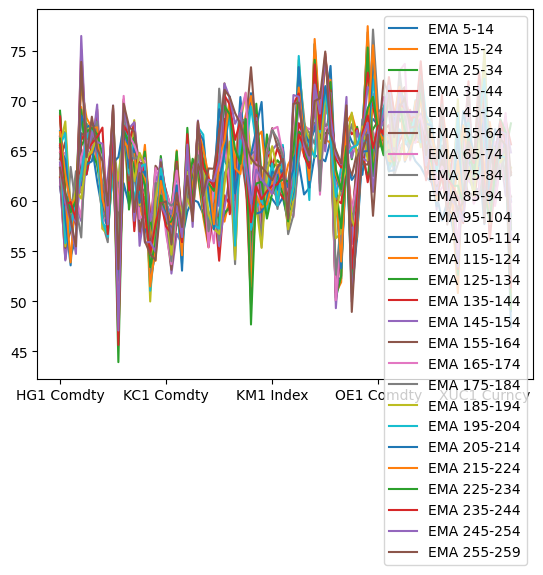

In [30]:
binned_calcs_df.plot()

In [31]:
def count_values_above_threshold(df, threshold=60):
    """
    Count how many values in each column of the DataFrame are greater than a given threshold.

    Parameters:
    - df (pd.DataFrame): The input DataFrame where rows are assets and columns are EMA periods.
    - threshold (int or float): The value to compare against. Default is 60.

    Returns:
    - pd.Series: A Series where the index is the column name and the value is the count of rows greater than the threshold.
    """
    # Apply the condition df > threshold, which returns a boolean DataFrame
    # Then sum the True values (which correspond to values > threshold) column-wise
    count_above_threshold = (df > threshold).sum(axis=0) / len(df) * 100
    
    return count_above_threshold

# Example usage
# Assuming `binned_calcs_df` is the DataFrame with rows as assets and columns as EMA bins
counts_above_60 = count_values_above_threshold(binned_calcs_df, threshold=60)

# Display the result
print(counts_above_60)


EMA 5-14      63
EMA 15-24     76
EMA 25-34     71
EMA 35-44     73
EMA 45-54     69
EMA 55-64     74
EMA 65-74     72
EMA 75-84     73
EMA 85-94     78
EMA 95-104    80
EMA 105-114   80
EMA 115-124   83
EMA 125-134   79
EMA 135-144   78
EMA 145-154   80
EMA 155-164   83
EMA 165-174   85
EMA 175-184   80
EMA 185-194   76
EMA 195-204   72
EMA 205-214   76
EMA 215-224   78
EMA 225-234   79
EMA 235-244   77
EMA 245-254   72
EMA 255-259   74
dtype: float64


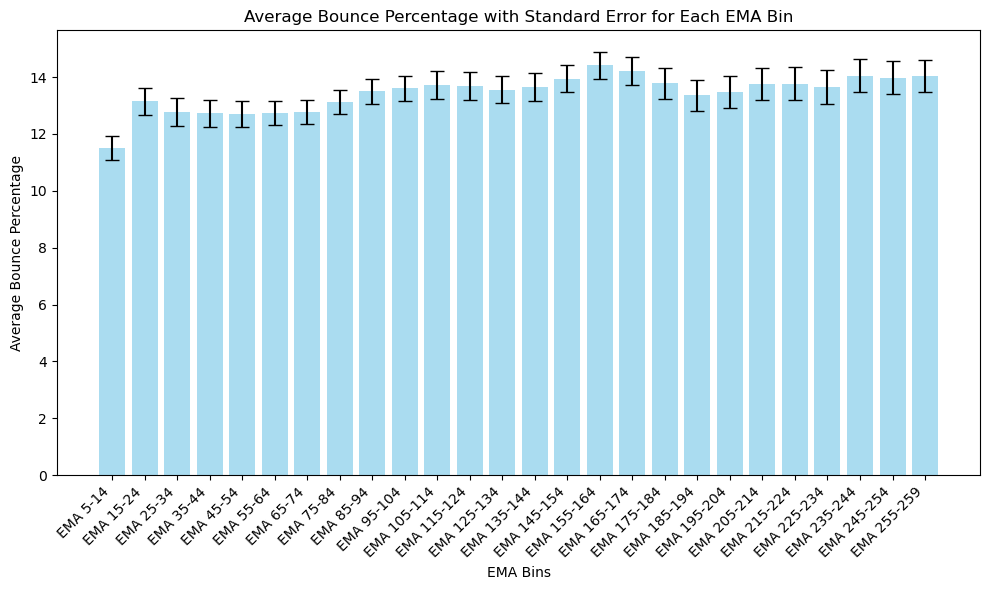

In [35]:
def plot_ema_bin_statistics(df):
    """
    Plot the mean and standard error of each bin in a box plot.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame where rows are assets and columns are EMA bins.
    """
    # Calculate mean and standard error for each column (bin)
    means = df.mean(axis=0)
    sems = df.sem(axis=0)  # Standard error of the mean

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the means as bars and standard error as error bars
    ax.bar(means.index, means - 50, yerr=sems, capsize=5, color='skyblue', alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel('EMA Bins')
    ax.set_ylabel('Average Bounce Percentage')
    ax.set_title('Average Bounce Percentage with Standard Error for Each EMA Bin')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `binned_calcs_df` is the DataFrame with rows as assets and columns as EMA bins
plot_ema_bin_statistics(binned_calcs_df)


In [33]:
binned_calcs_df.mean(axis=0)

EMA 5-14      62
EMA 15-24     63
EMA 25-34     63
EMA 35-44     63
EMA 45-54     63
EMA 55-64     63
EMA 65-74     63
EMA 75-84     63
EMA 85-94     63
EMA 95-104    64
EMA 105-114   64
EMA 115-124   64
EMA 125-134   64
EMA 135-144   64
EMA 145-154   64
EMA 155-164   64
EMA 165-174   64
EMA 175-184   64
EMA 185-194   63
EMA 195-204   63
EMA 205-214   64
EMA 215-224   64
EMA 225-234   64
EMA 235-244   64
EMA 245-254   64
EMA 255-259   64
dtype: float64

In [50]:
calcs.to_clipboard()